<a href="https://colab.research.google.com/github/jgottling/2c2020-tp2ia-dataset/blob/main/Trabajo_pr%C3%A1ctico_N%C2%B02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 0. Mount your drive content if not mounted yet

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#sólo clonarlo la primera vez, descomentando esto
#%cd /content/drive/My Drive/

#! git clone https://github.com/jgottling/2c2020-tp2ia-dataset.git




In [ ]:
#actualizar el dataset
#%cd /content/drive/My Drive/2c2020-tp2ia-dataset

#! git pull

#### 1. Install tensorflow dependency

In [ ]:
!pip install tensorflow


shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
The folder you are executing pip from can no longer be found.


#### 2. Import dependencies

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds

import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import cv2                                 
from tqdm import tqdm

from skimage.io import imread
from keras.layers import Input, Dense

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from skimage import transform
from skimage.color import rgb2gray
from collections import Counter
from keras.utils import plot_model
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

from PIL import Image

import pandas as pd

#### 3. Parameters

In [ ]:
# Segun la posicion se asocian al nro de carpeta. 
# Carpeta 0 equivale a posicion 0 de este array es decir al betta.
classNames = ['Betta macho', 'Blue tang', 'Botia payaso', 'Cola de espada macho', 'Disco','Payaso']

classNamesLabel = {classNames:i for i, classNames in enumerate(classNames)}
nbClasses = len(classNames)
imageSize = (32, 32)

imageShape = (32, 32)
inputLayer = imageShape[0] * imageShape[1]
outputLayer = f'{len(classNames)}'
hiddenLayers = [512, 64, 128, 64]
epochs = 500
batchSize = 64
learningRate = 0.0001

#### 4. Define auxiliar functions

##### loadData

In [ ]:
def loadData(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    label_index = 0
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) 
                      if (f.endswith(".jpg") or f.endswith(".jpeg"))]
        for f in file_names:
            np.array(f)
            images.append(imread(f))
            labels.append(label_index)
        label_index = label_index + 1
    return np.array(images), np.array(labels)


##### showImages

In [ ]:
def showImages(images, classWithQuantity):
  total = 0
  fig = plt.figure(figsize=(50, 50))
  for i in range(len(classNames)):
    nameIndex, quantity = classWithQuantity[i]
    plt.subplot(2, 6, 1 + i)
    plt.axis('off')
    plt.imshow(images[total],  cmap="gray")
    plt.title(classNames[nameIndex], fontsize = 50)
    total = total + quantity

##### plotConfusionMatrix

In [ ]:
def plotConfusionMatrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

##### fullMulticastReport

In [ ]:
## multiclass or binary report
## If binary (sigmoid output), set binary parameter to True
def fullMulticlassReport(model,
                           x,
                           y_true,
                           batch_size=32,
                           binary=False):

    # 1. Transform one-hot encoded y_true into their class number
    if not binary:
        y_true = np.argmax(y_true,axis=1)
    
    # 2. Predict classes and stores in y_pred
    y_pred = model.predict_classes(x, batch_size=batch_size)
    
    # 3. Print accuracy score
    print("Accuracy : "+ str(accuracy_score(y_true,y_pred)))
    
    print("")
    
    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true,y_pred,digits=5))    
    
    # 5. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true,y_pred)
    print(cnf_matrix)
    #plotConfusionMatrix(cnf_matrix,classes=classes)

##### plotHistory

In [ ]:
def plotHistory(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

##### plotAccuracyLoss

In [ ]:
def plotAccuracyLoss(history):
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

##### plotImage

In [ ]:
def plotImage(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

##### plotValueArray

In [ ]:
def plotValueArray(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(6), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

##### plot

In [ ]:
def plot(predictions, test_labels, test_images):
  for i in range(len(predictions)):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plotImage(i, predictions[i], test_labels, test_images)
    plt.subplot(1,2,2)
    plotValueArray(i, predictions[i],  test_labels)
    plt.show()

##### printMislabeledImages

In [ ]:
def printMislabeledImages(class_names, test_images, test_labels, pred_labels):
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels, title)

##### confusionMatrix

In [ ]:
def confusionMatrix(test_labels, pred_labels):
  CM = confusion_matrix(test_labels, pred_labels)
  ax = plt.axes()
  sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=classNames, 
           yticklabels=classNames, ax = ax)
  ax.set_title('Confusion matrix')
  plt.show()

##### displayExamples

In [ ]:
def displayExamples(class_names, images, labels, title):
    fig = plt.figure(figsize=(10,10))
    fig.suptitle(title, fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

##### displayRandomImage

In [ ]:
def displayRandomImage(class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

#### 5. Load & Show training data & testing data


In [ ]:
ROOT_PATH = "/content/drive/My Drive/2c2020-tp2ia-dataset"
train_data_directory = os.path.join(ROOT_PATH, "training")
test_data_directory = os.path.join(ROOT_PATH, "testing")

train_images, train_labels = loadData(train_data_directory)
test_images, test_labels = loadData(test_data_directory)

In [ ]:
# Muestro ejemplos de entrenamiento
values, counts = np.unique(train_labels, return_counts = True)
classWithQuantityTrain = list(zip(values, counts))
total = 0

print("Training Examples")
for nameIndex, quantity in classWithQuantityTrain:
  print(classNames[nameIndex], "example from total", quantity)
  display(Image.fromarray(train_images[total], 'RGB'))
  total = total + quantity

# Muestro ejemplos de testing
values, counts = np.unique(test_labels, return_counts = True)
classWithQuantityTest = list(zip(values, counts))
total = 0

print("Testing Examples")
for nameIndex, quantity in classWithQuantityTest:
  print(classNames[nameIndex], "example from total", quantity)
  display(Image.fromarray(test_images[total], 'RGB'))
  total = total + quantity

In [ ]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts, 'test': test_counts}, 
             index=classNames).plot.bar()
plt.show()

In [ ]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=classNames,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [ ]:
plt.pie(test_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=classNames,
        autopct='%1.1f%%')
plt.axis('equal')
plt.show()

In [ ]:
displayRandomImage(classNames, train_images, train_labels)

In [ ]:
train_images_shuffle, train_labels_shuffle = shuffle(train_images, train_labels, random_state=25)

displayExamples(classNames, train_images_shuffle, train_labels_shuffle, "Some examples of images of the dataset")

In [ ]:
train_images_shuffle, train_labels_shuffle = shuffle(test_images, test_labels, random_state=25)

displayExamples(classNames, train_images_shuffle, train_labels_shuffle, "Some examples of images of the dataset")

#### 6. Pre-processing data


In [ ]:
# Convierto a blanco y negro; y cambio el tamaño
train_images32 = [transform.resize(image, (32,32)) for image in train_images]
train_images32 = np.array(train_images32)
test_images32 = [transform.resize(image, (32,32)) for image in test_images]
test_images32 = np.array(test_images32)

train_images_gray = rgb2gray(train_images32)
test_images_gray = rgb2gray(test_images32)

In [ ]:
print(f"{train_images_gray.shape[0]} training images found in {train_images_gray.shape[1]}x{train_images_gray.shape[2]}")
print(f"{test_images_gray.shape[0]} testing images found in {test_images_gray.shape[1]}x{test_images_gray.shape[2]}")

805 training images found in 32x32
274 testing images found in 32x32


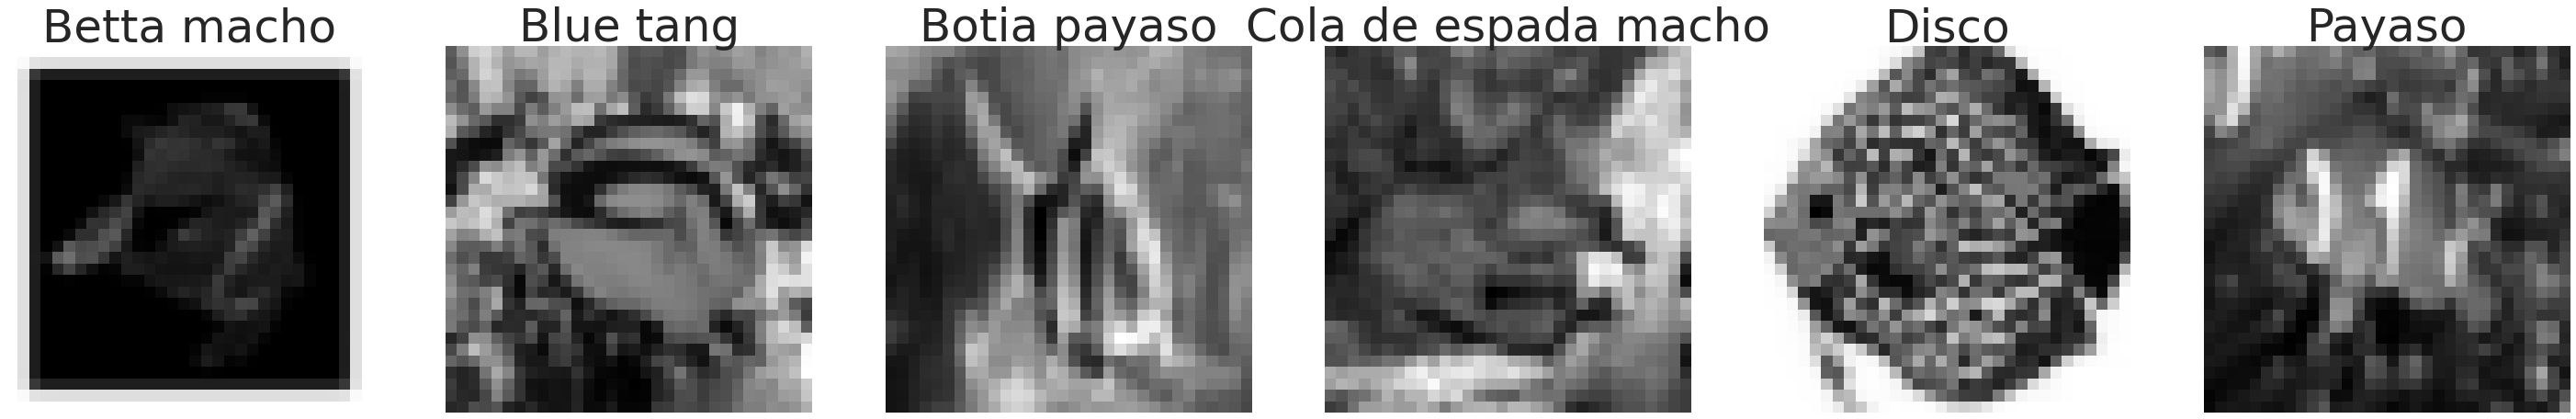

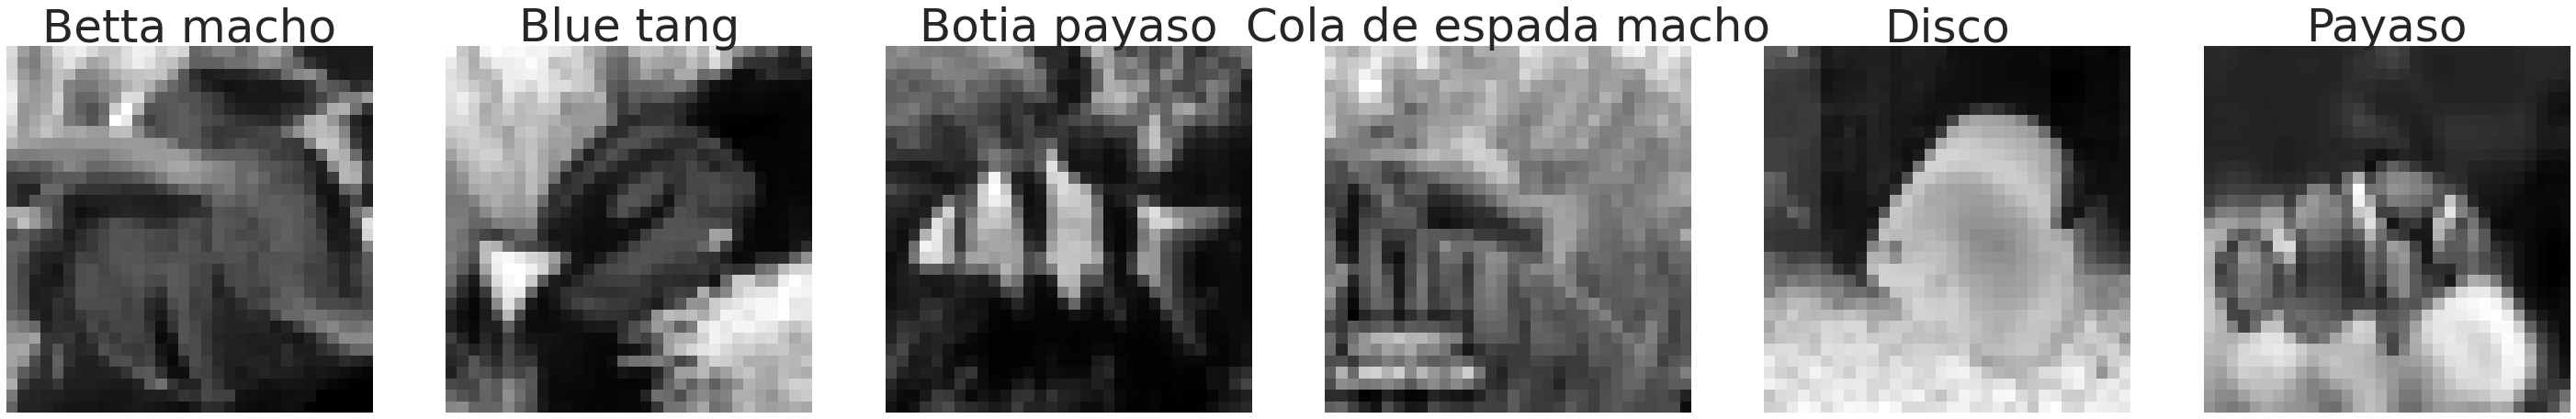

In [ ]:
showImages(train_images_gray, classWithQuantityTrain)
showImages(test_images_gray, classWithQuantityTest)

#### 7. Model construction

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = imageShape, name = "input"),
    keras.layers.Dense(hiddenLayers[0], activation='relu', name = "hidden1"),
    keras.layers.Dense(hiddenLayers[1], activation='relu', name = "hidden2"),
    keras.layers.Dense(hiddenLayers[2], activation='relu', name = "hidden3"),
    #keras.layers.Dense(hiddenLayers[3], activation='relu', name = "hidden4"),
    keras.layers.Dropout(0.3, name="dropout"),
    keras.layers.Dense(outputLayer, activation='softmax', name="output")
])

model.compile(#optimizer="adam", 
              keras.optimizers.Adam(lr=learningRate, decay=learningRate / 100),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

model.summary()
plot_model(model, show_layer_names=True, show_shapes=True)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 1024)              0         
_________________________________________________________________
hidden1 (Dense)              (None, 512)               524800    
_________________________________________________________________
hidden2 (Dense)              (None, 64)                32832     
_________________________________________________________________
hidden3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 6)                 774       
Total params: 566,726
Trainable params: 566,726
Non-trainable params: 0
_______________________________________________

OSError: ignored

#### 8. Model training

In [ ]:
history = model.fit(np.array(train_images_gray), 
                    train_labels,
                    batch_size = batchSize,
                    epochs = epochs)

Epoch 1/500
13/13 [==============================] - 0s 2ms/step - loss: 1.7129 - accuracy: 0.3056
Epoch 2/500
13/13 [==============================] - 0s 3ms/step - loss: 1.6846 - accuracy: 0.3267
Epoch 3/500
13/13 [==============================] - 0s 3ms/step - loss: 1.6693 - accuracy: 0.3329
Epoch 4/500
13/13 [==============================] - 0s 3ms/step - loss: 1.6459 - accuracy: 0.3826
Epoch 5/500
13/13 [==============================] - 0s 3ms/step - loss: 1.6333 - accuracy: 0.4112
Epoch 6/500
13/13 [==============================] - 0s 2ms/step - loss: 1.5835 - accuracy: 0.4522
Epoch 7/500
13/13 [==============================] - 0s 2ms/step - loss: 1.5553 - accuracy: 0.4957
Epoch 8/500
13/13 [==============================] - 0s 3ms/step - loss: 1.5600 - accuracy: 0.4820
Epoch 9/500
13/13 [==============================] - 0s 2ms/step - loss: 1.5289 - accuracy: 0.5093
Epoch 10/500
13/13 [==============================] - 0s 2ms/step - loss: 1.5290 - accuracy: 0.5118
Epoch 11/

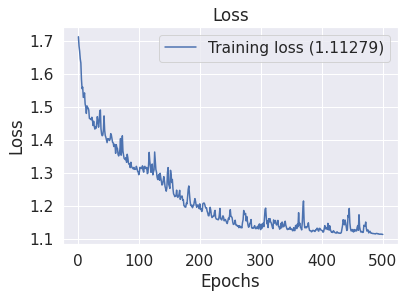

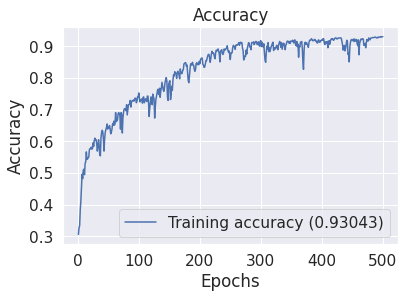

In [ ]:
plotHistory(history)

#### 9. Model evaluation

In [ ]:
test_loss, test_acc = model.evaluate(test_images_gray,  test_labels, verbose=2)
print("\n-Model evaluation: ")
print('Test accuracy:', test_acc)
print('Test less:', test_loss)

9/9 - 0s - loss: 1.7916 - accuracy: 0.1715

-Model evaluation: 
Test accuracy: 0.17153283953666687
Test less: 1.7915759086608887


In [ ]:
predictions = model.predict(test_images_gray)
pred_labels = np.argmax(predictions, axis = 1)

display_random_image(classNames, test_images, pred_labels)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-213-0fc204651de8>", line 4, in <module>
    display_random_image(classNames, test_images, pred_labels)
NameError: name 'display_random_image' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/l

NameError: ignored

In [ ]:
printMislabeledImages(classNames, test_images, test_labels, pred_labels)

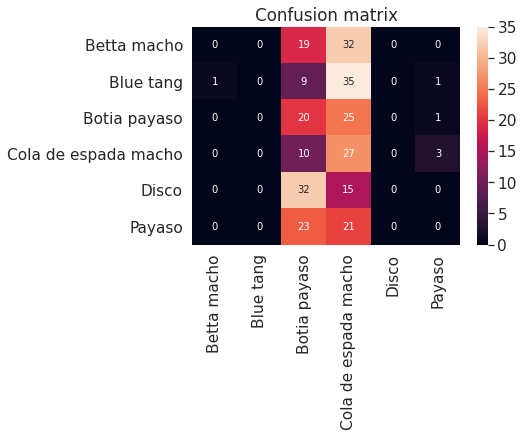

In [ ]:
confusionMatrix(test_labels, pred_labels)

In [ ]:
predictions = model.predict(test_images_gray)

Y_pred = model.predict_generator(test_images_gray, len(test_images_gray) // 32 + 1)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=classNames, zero_division=0))

In [ ]:
plot(predictions, test_labels, test_images)

#### Data augmentation

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(32, 32),
  layers.experimental.preprocessing.Rescaling(1./255),
])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)
])

x = tf.expand_dims(train_images_gray[0], 0)

fig = plt.figure(figsize=(10, 10))
aug_train = []
for i in range(9):
  #y = resize_and_rescale(x)
  z = data_augmentation(y)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(z[0])
  plt.axis("off")
  t = tf.squeeze(z)
  aug_train.append(t)